<a href="https://colab.research.google.com/github/llcorrea/time_series_forecasting/blob/main/Time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project's description**

Data science project for time series analysis and forecasting using as case study the total daily revenue earned from sales of a given product over time.

---
##**Project's goal**

Given the sales time series, the goal is to accomplish some tasks on analysis and dataset transformation, and then apply some algorithms for revenue forecasting.

---
##**Task's description**

**The forecasting is to explain the future sales revenue based on the past sales data (extrapolation).**

Forecasting involves the generation of a set of numbers that corresponds to a future occurrence. In our case, future occurrences are the sales revenue over a time period.

> Forecasting is based on some assumptions, which will be explored in this project:
  * The past will repeat itself in a given moment.
  * As the forecast horizon shortens, forecast accuracy increases.
  * Forecasts are rarely accurate, and they are almost never totally accurate.
  * Thus, it is recommended to adopt a *forecast range* for better business planning.

# **Importing libs**

In [118]:
from google.colab import files
import io
import requests
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pdb
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [8, 6]

#**Useful functions**

In [119]:
def dataset_description(df_obj):
  ##describe the dataset
  print('Dataset shape: %s\n' % (df_obj.shape, ))
  print('Dataset columns: %s\n' % df_obj.columns)
  
  print('Dataset first and last rows:\n' % df_obj.columns)
  display(df_obj)
  #display(df_obj.head())
  #display(df_obj.tail())
  
  print('\nColumns description:\n')
  display(df_obj.info())
  display(df_obj.describe())
  
  print('\nNull values:\n')
  display(df_obj.isnull().sum())

# **Loading dataset**

In [120]:
##load from github
url = 'https://raw.githubusercontent.com/llcorrea/time_series_forecasting/main/data.csv'
daily_ts = pd.read_csv(url)

daily_ts.rename(columns={'Unnamed: 0': 'occurrence'}, inplace=True)
daily_ts.rename(columns={'y': 'revenue'}, inplace=True)
daily_ts

,occurrence,revenue,x1
0,1,106.086805,88.215129
1,2,106.282473,88.484153
2,3,106.623687,87.876842
3,4,105.602062,86.779543
4,5,101.096083,84.622428
...,...,...,...
1090,1091,92.600113,74.997458
1091,1092,92.222724,75.896572
1092,1093,91.966649,76.245927
1093,1094,90.827749,75.523824


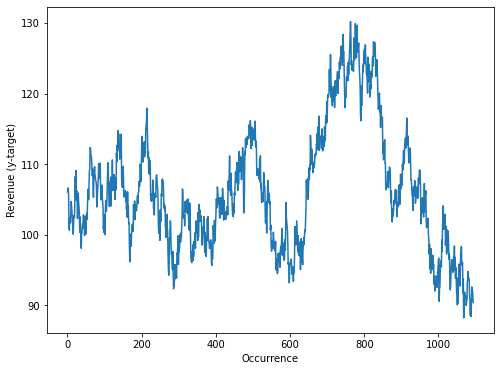

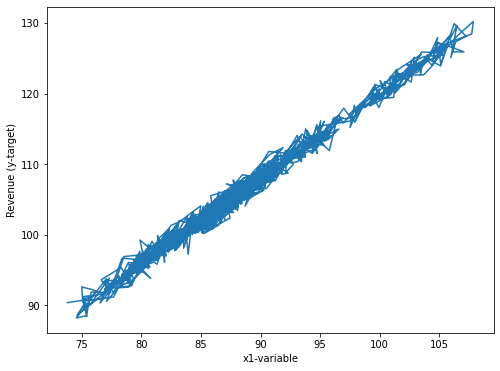

In [121]:
daily_ts['revenue'].plot()
plt.ylabel('Revenue (y-target)')
plt.xlabel('Occurrence')
plt.show()

plt.plot(daily_ts['x1'], daily_ts['revenue'])
plt.ylabel('Revenue (y-target)')
plt.xlabel('x1-variable')
plt.show()

# **Time series analysis**
> **Dataset size:** 1095 entries\
> **Total columns:** 2 columns plus an index column\
> **Total features:** 2 features\
> **Target feature:** The target feature shows the daily sales revenue of a given product.\
> **Problem definition:** The target (sales revenue) is used to forecast future revenues.

* Each entry represents the total daily revenue.

> **Type of features:**
  
* Only numerical features.

> **Missing data:**

* There are no null data in any of the dataset columns.

In [122]:
dataset_description(daily_ts)

Dataset shape: (1095, 3)

Dataset columns: Index(['occurrence', 'revenue', 'x1'], dtype='object')

Dataset first and last rows:



,occurrence,revenue,x1
0,1,106.086805,88.215129
1,2,106.282473,88.484153
2,3,106.623687,87.876842
3,4,105.602062,86.779543
4,5,101.096083,84.622428
...,...,...,...
1090,1091,92.600113,74.997458
1091,1092,92.222724,75.896572
1092,1093,91.966649,76.245927
1093,1094,90.827749,75.523824



Columns description:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   occurrence  1095 non-null   int64  
 1   revenue     1095 non-null   float64
 2   x1          1095 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 25.8 KB


None

,occurrence,revenue,x1
count,1095.000000,1095.000000,1095.000000
mean,548.000000,106.235083,88.522971
std,316.243577,8.762242,7.266223
min,1.000000,88.207227,73.802380
25%,274.500000,100.032195,83.184386
50%,548.000000,105.138625,87.602882
75%,821.500000,111.112265,92.309012
max,1095.000000,130.205935,107.855982



Null values:



occurrence    0
revenue       0
x1            0
dtype: int64

### **Dataset transformation:**

> Creation of a *fake date* column to handle the revenue (y-target) for each entry of the dataset.
> 
> **In this project, we assume that each dataset row represents the daily sales revenue.**

,occurrence,revenue,x1
daily_data,,,
2018-01-01,1,106.086805,88.215129
2018-01-02,2,106.282473,88.484153
2018-01-03,3,106.623687,87.876842
2018-01-04,4,105.602062,86.779543
2018-01-05,5,101.096083,84.622428
...,...,...,...
2020-12-26,1091,92.600113,74.997458
2020-12-27,1092,92.222724,75.896572
2020-12-28,1093,91.966649,76.245927


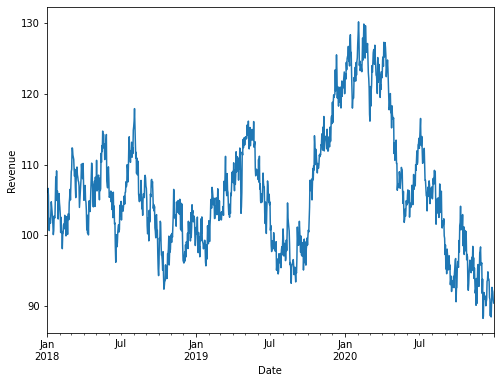

In [123]:
#df_time_series['f_data'] = pd.to_datetime(df_time_series['occurrence'])

##creation of a fake date column to handle the sales per each entry (which means a day is a row in the dataset)
daily_ts["daily_data"] = pd.date_range('2018-01-01', '2020-12-30')
daily_ts = daily_ts.set_index('daily_data')
daily_ts.index
display(daily_ts)

daily_ts['revenue'].plot()
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.show()

> **Time series created from the daily one with distinct time periods:**

In [124]:
weekly_ts=daily_ts.groupby(pd.Grouper(freq='W')).sum()
weekly_ts.index.rename('weekly_data', inplace=True)
#display(weekly_ts)

monthly_ts=daily_ts.groupby(pd.Grouper(freq='M')).sum()
monthly_ts.index.rename('monthly_data', inplace=True)

### **Stationarity and STL decomposition:**

STL means seasonal and trend decomposition using Loess analysis to inspect stationarity. STL plots are used to decompose the time series and analyze each of its component individually.

Generally, time series present common behaviors where computational models may need to identify the causes of such behaviors. Some of them may be patterns or simply random variations over time. Among the patterns are:

* Trends, which are long-term movements (up or down) in the data.
* Seasonality, which produces short-term variations that are usually related to the time of year, month, or even a particular day.
* Cycles, which are wavelike variations lasting more than a year that are usually tied to economic or political conditions.
* Irregular variations that do not reflect typical behavior, such as a period of extreme weather or a union strike.
* Random variations, which encompass all non-typical behaviors not accounted for by the other classifications.

Thus, the intrinsic components of a time series can be explored to support the forescasting models.

Reference: https://www.referenceforbusiness.com/management/Ex-Gov/Forecasting.html





### **Dickey-Fuller criterion:**

> Checking stationarity in the daily time series, Dickey-Fuller criterion does not reject the non-stationarity null-hypothesis (**p=0.152**). In addition it is possible to verify it by visually checking the plots that the time series does not have clear trends or seasons.

Dickey-Fuller criterion: p=0.151654


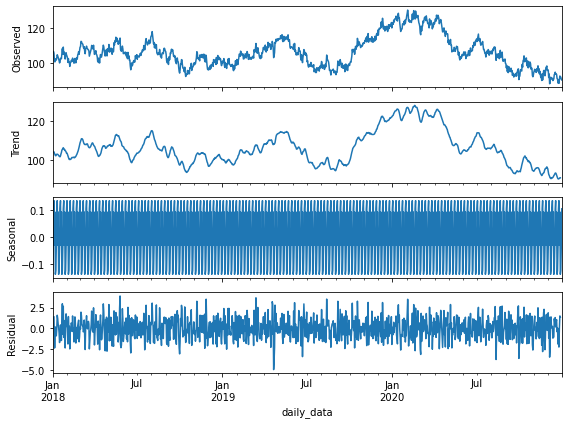

In [125]:
sm.tsa.seasonal_decompose(daily_ts['revenue']).plot()
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(daily_ts['revenue'])[1])

> Dickey-Fuller criterion for weekly time series: **p=0.989**. 
>
>The test does not reject the non-stationarity null-hypothesis for weekly data.

Dickey-Fuller criterion: p=0.989049


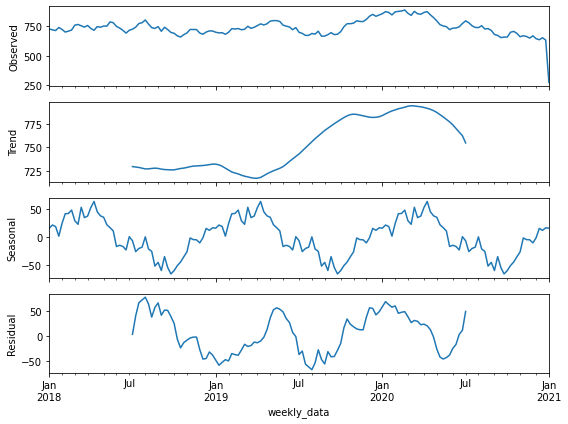

In [126]:
sm.tsa.seasonal_decompose(weekly_ts['revenue']).plot()
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(weekly_ts['revenue'])[1])

> Dickey-Fuller criterion for monthly time series: **p=0.15**. 
>
>The test does not reject the non-stationarity null-hypothesis for monthly data.

Dickey-Fuller criterion: p=0.149991


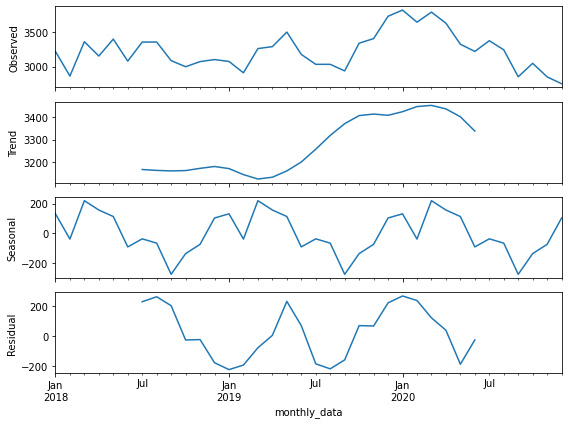

In [127]:
sm.tsa.seasonal_decompose(monthly_ts['revenue']).plot()
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(monthly_ts['revenue'])[1])

### **Time series differentiation:**

As the Dickey-Fuller criterion does not reject the non-stationarity null-hypothesis for any time series, it's necessary to perform other transformations. 

> Time series differentiation are used to remove seasonalities and trends and make the series stationary. 

We will use the *daily and monthly time series* as they presented the lowest *p*-values in Dickey-Fuller criterion.


Dickey-Fuller criterion: p=0.000000


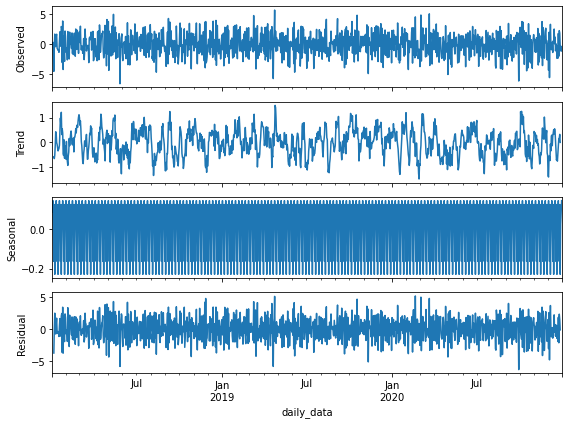

In [128]:
diff_shift=1 #time period in days to shift
daily_ts['revenue_diff'] = daily_ts['revenue'] - daily_ts['revenue'].shift(diff_shift)
sm.tsa.seasonal_decompose(daily_ts['revenue_diff'][diff_shift:]).plot()
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(daily_ts['revenue_diff'][diff_shift:])[1])

Dickey-Fuller criterion: p=0.000000


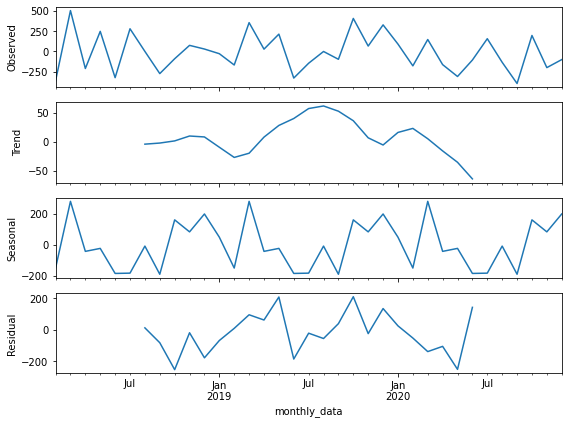

In [129]:
diff_shift=1 #time period in months to shift
monthly_ts['revenue_diff'] = monthly_ts['revenue'] - monthly_ts['revenue'].shift(diff_shift)
sm.tsa.seasonal_decompose(monthly_ts['revenue_diff'][diff_shift:]).plot()
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(monthly_ts['revenue_diff'][diff_shift:])[1])

**After differentiation, non-stationarity hypothesis is now rejected according to the Dickey-Fuller criterion with p=0.0 for both time series.**

In [130]:
daily_ts[['revenue', 'revenue_diff']].head(20)

,revenue,revenue_diff
daily_data,,
2018-01-01,106.086805,NaN
2018-01-02,106.282473,0.195668
2018-01-03,106.623687,0.341214
2018-01-04,105.602062,-1.021625
2018-01-05,101.096083,-4.505979
2018-01-06,100.644707,-0.451377
2018-01-07,102.363133,1.718426
2018-01-08,101.968778,-0.394355
2018-01-09,101.690857,-0.277921


In [131]:
monthly_ts[['revenue', 'revenue_diff']]

,revenue,revenue_diff
monthly_data,,
2018-01-31,3221.033705,NaN
2018-02-28,2860.160995,-360.872710
2018-03-31,3363.482415,503.321420
2018-04-30,3153.792858,-209.689558
2018-05-31,3401.369470,247.576612
2018-06-30,3078.822437,-322.547033
2018-07-31,3358.157273,279.334836
2018-08-31,3358.850248,0.692975
2018-09-30,3086.426054,-272.424194


In [132]:
##ACF for TS
#sm.graphics.tsa.plot_acf(daily_ts['revenue_diff'][1:].values.squeeze())
#plt.show()
#sm.graphics.tsa.plot_acf(monthly_ts['revenue_diff'][1:].values.squeeze())
#plt.show()

# **Time series models**

### **ARIMA method:**

**The focus now will on the *monthly time series*.**

**Parameter selection:**

Initial guess values for ARIMA: Q=2, q=1, P=2, p=2.


In [133]:
p_s = range(0, 3)
d=1
q_s = range(0, 1)
P_s = range(0, 3)
D=1
Q_s = range(0, 3)

params = product(p_s, q_s, P_s, Q_s)
params_list = list(params)

**Parameter tuning:**

In [134]:
warnings.filterwarnings('ignore')

results = []
best_aic = float("inf")
for param_set in params_list:
    #some parameter combinations are not valid
    try:
        model=sm.tsa.statespace.SARIMAX(monthly_ts['revenue'], order=(param_set[0], d, param_set[1]), seasonal_order=(param_set[2], D, param_set[3], 1)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param_set)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_params = param_set
    results.append([param_set, model.aic])
    
warnings.filterwarnings('default')

**Tuning results:**

In [135]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
4   (0, 0, 1, 1)  471.465893
10  (1, 0, 0, 1)  471.467966
2   (0, 0, 0, 2)  472.396140
5   (0, 0, 1, 2)  472.551202
11  (1, 0, 0, 2)  472.551202


**Best model:**

In [136]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                           revenue   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 1)   Log Likelihood                -232.733
Date:                           Wed, 22 Sep 2021   AIC                            471.466
Time:                                   02:09:41   BIC                            476.045
Sample:                               01-31-2018   HQIC                           473.027
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L1       -0.3252      0.185     -1.754      0.079      -0.689       0.038
ma.S.L1       -0.9392      0.198     -4.754

**Residual errors of best model:**

Student's criterion: p=0.232739
Dickey-Fuller criterion: p=0.000000


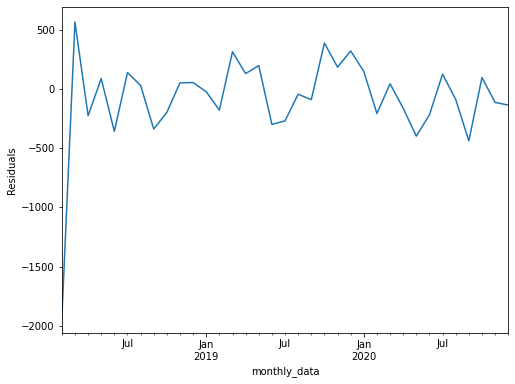

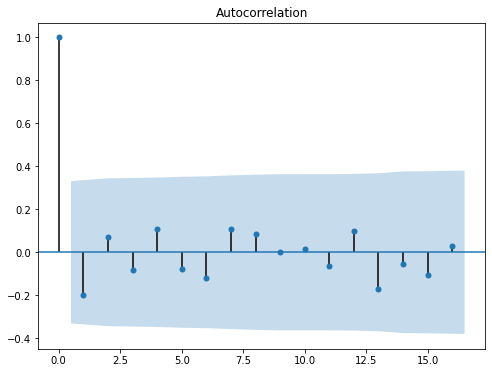

In [137]:
best_model.resid[1:].plot()
plt.ylabel('Residuals')

sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze())

print("Student's criterion: p=%f" % stats.ttest_1samp(best_model.resid[1:], 0)[1])
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])


**Fitting data:**

As residuals are not biased (Student's criterion), are stationary (Dickey-Fuller criterion) and not auto-correlated (Ljung-Box criterion and correlogram), it's time to fit the data.



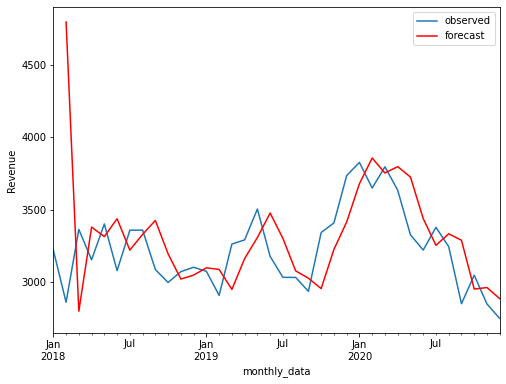

In [138]:
monthly_ts['forecast_model'] = best_model.fittedvalues
monthly_ts['revenue'].plot(label='observed')
monthly_ts['forecast_model'][1:].plot(color='r', label='forecast')
plt.ylabel('Revenue')
plt.legend()

### **Forecasting:**

Extrapolating the monthly time series to forecast future revenues based on the past data with ARIMA method, previously created.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,revenue,forecast
2018-01-31,3221.033705,NaN
2018-02-28,2860.160995,4797.822716
2018-03-31,3363.482415,2798.447268
2018-04-30,3153.792858,3379.859778
2018-05-31,3401.369470,3313.867099
2018-06-30,3078.822437,3437.467629
2018-07-31,3358.157273,3220.442881
2018-08-31,3358.850248,3329.488159
2018-09-30,3086.426054,3425.460780
2018-10-31,2996.804464,3194.411309


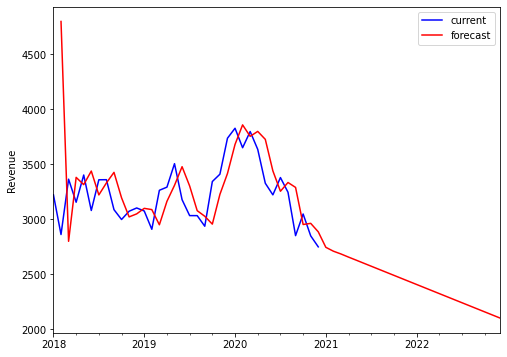

In [139]:
from dateutil.relativedelta import relativedelta
future_monthly_ts = monthly_ts[['revenue']]
date_list = [pd.datetime.strptime("2021-01-31", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)] #forecasting 12 months ahead
date_ts = pd.DataFrame(index=date_list, columns=future_monthly_ts.columns)
future_monthly_ts = pd.concat([future_monthly_ts, date_ts])

future_monthly_ts['forecast'] = best_model.predict(start=1, end=59)
display(future_monthly_ts)

future_monthly_ts['revenue'].plot(color='b', label='current')
future_monthly_ts['forecast'].plot(color='r', label='forecast')
plt.ylabel('Revenue')
plt.legend()